**IMPORTING LIBRARIES**

In [ ]:
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Matplot Images
import matplotlib.image as mpimg
# Tensflor and Keras Layer and Model and Optimize and Loss
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
#Kernel Intilizer
from sklearn.preprocessing import LabelEncoder
# import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam , Adamax
#PreTrained Model
from tensorflow.keras.applications import *
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
# Warnings Remove
import warnings
warnings.filterwarnings("ignore")

**LOAD DATA**

In [ ]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory containing the dataset
directory = "/content/drive/MyDrive/pneumonia detection/chest_xray/train"

# Load file paths and labels into a DataFrame
filepath = []
label = []
folds = os.listdir(directory)
for fold in folds:
    f_path = os.path.join(directory, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        filepath.append(img_path)
        label.append(fold)

file_path_series = pd.Series(filepath, name='filepath')
label_series = pd.Series(label, name='label')
df_train = pd.concat([file_path_series, label_series], axis=1)

# Display DataFrame
print("Data loaded into DataFrame:")
print(df_train.head())

# Now you can proceed with loading the images using an ImageDataGenerator
# Define parameters for image augmentation if needed
# Example:
# image_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
# train_generator = image_data_generator.flow_from_dataframe(dataframe=df_train, x_col='filepath', y_col='label', target_size=(224, 224), batch_size=32, class_mode='binary')

# Use the flow_from_dataframe method to load images from DataFrame
# Example:
# train_generator = image_data_generator.flow_from_dataframe(dataframe=df_train, x_col='filepath', y_col='label', target_size=(224, 224), batch_size=32, class_mode='binary')

# Now you can use train_generator to train your model


Mounted at /content/drive
Data loaded into DataFrame:
                                            filepath   label
0  /content/drive/MyDrive/pneumonia detection/che...  NORMAL
1  /content/drive/MyDrive/pneumonia detection/che...  NORMAL
2  /content/drive/MyDrive/pneumonia detection/che...  NORMAL
3  /content/drive/MyDrive/pneumonia detection/che...  NORMAL
4  /content/drive/MyDrive/pneumonia detection/che...  NORMAL


In [ ]:
df_train

,filepath,label
0,/content/drive/MyDrive/pneumonia detection/che...,NORMAL
1,/content/drive/MyDrive/pneumonia detection/che...,NORMAL
2,/content/drive/MyDrive/pneumonia detection/che...,NORMAL
3,/content/drive/MyDrive/pneumonia detection/che...,NORMAL
4,/content/drive/MyDrive/pneumonia detection/che...,NORMAL
...,...,...
5212,/content/drive/MyDrive/pneumonia detection/che...,PNEUMONIA
5213,/content/drive/MyDrive/pneumonia detection/che...,PNEUMONIA
5214,/content/drive/MyDrive/pneumonia detection/che...,PNEUMONIA
5215,/content/drive/MyDrive/pneumonia detection/che...,PNEUMONIA


In [ ]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the directory containing the dataset
directory = "/content/drive/MyDrive/pneumonia detection/chest_xray/test"

# Load file paths and labels into a DataFrame
filepath = []
label = []
folds = os.listdir(directory)
for fold in folds:
    f_path = os.path.join(directory, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        filepath.append(img_path)
        label.append(fold)

file_path_series = pd.Series(filepath, name='filepath')
label_series = pd.Series(label, name='label')
df_test = pd.concat([file_path_series, label_series], axis=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_test.sample(5)

,filepath,label
435,/content/drive/MyDrive/pneumonia detection/che...,PNEUMONIA
312,/content/drive/MyDrive/pneumonia detection/che...,PNEUMONIA
623,/content/drive/MyDrive/pneumonia detection/che...,PNEUMONIA
318,/content/drive/MyDrive/pneumonia detection/che...,PNEUMONIA
148,/content/drive/MyDrive/pneumonia detection/che...,NORMAL


In [ ]:
print(f"The shape of The Train data is: {df_train.shape}")
print(f"The shape of The Test data is: {df_test.shape}")

The shape of The Train data is: (5217, 2)
The shape of The Test data is: (624, 2)


**MAKING TRAIN TEST AND VALIDATION DATASET**

In [ ]:
data_dir = "/content/drive/MyDrive/pneumonia detection/chest_xray/train"
test_dir = "/content/drive/MyDrive/pneumonia detection/chest_xray/test"

IMAGE_SIZE = (256,256)

print('Training Images:')
# Creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

#Testing  Data
print('Validation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

Training Images:
Found 5217 files belonging to 2 classes.
Using 4696 files for training.
Validation Images:
Found 5217 files belonging to 2 classes.
Using 521 files for validation.
Testing Images:
Found 624 files belonging to 2 classes.


**ENCODING LABELS**

In [ ]:
train_labels = train_ds.class_names
test_labels = test_ds.class_names
validation_labels = validation_ds.class_names

# Encode Labels

# Define your class labels
class_labels = ['NORMAL', 'PNEUMONIA']

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the class labels
label_encoder.fit(class_labels)

# Transform the labels for training dataset
train_labels_encoded = label_encoder.transform(train_labels)

# Transform the labels for validation dataset
validation_labels_encoded = label_encoder.transform(validation_labels)

# Transform the labels for test dataset
test_labels_encoded = label_encoder.transform(test_labels)

In [ ]:
# Shape of the dataset
for image_batch, labels_batch in train_ds:
    print("Shape of X_train: ", image_batch.shape)
    print("Shape of y_train: ", labels_batch.shape)
    break

Shape of X_train:  (32, 256, 256, 3)
Shape of y_train:  (32,)


**NORMALIZING PIXEL VALUE**

In [ ]:
# Normalizing Pixel Values

# Train Data
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
# Val Data
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
# Test Data
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

**VISUAL COUNT OF TRAIN LABEL**

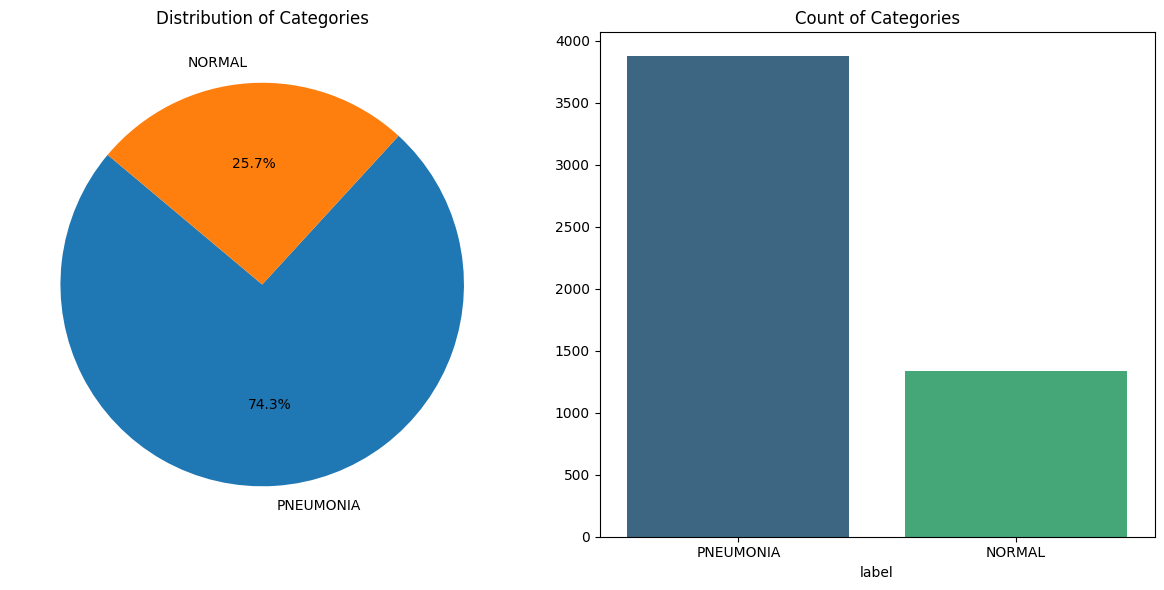

In [ ]:
count = df_train['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

VISUAL COUNT OF TEST LABEL

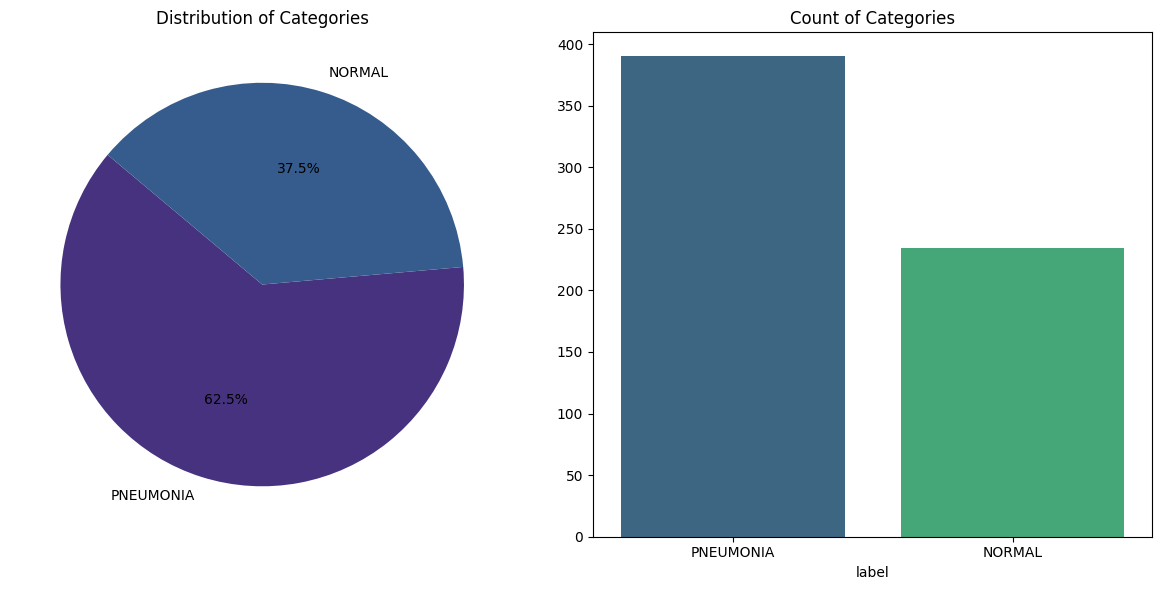

In [ ]:
count = df_test['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

VISUALIZING TRAIN IMAGES

In [ ]:
def visualize_images(path, num_images=5):
    # Get a list of image filenames in the specified path
    image_filenames = os.listdir(path)

    # Limit the number of images to visualize if there are more than num_images
    num_images = min(num_images, len(image_filenames))

    # Create a figure and axis object to display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='white')

    # Iterate over the selected images and display them
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # Load the image using Matplotlib
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)

        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

**NORMAL IMAGES**

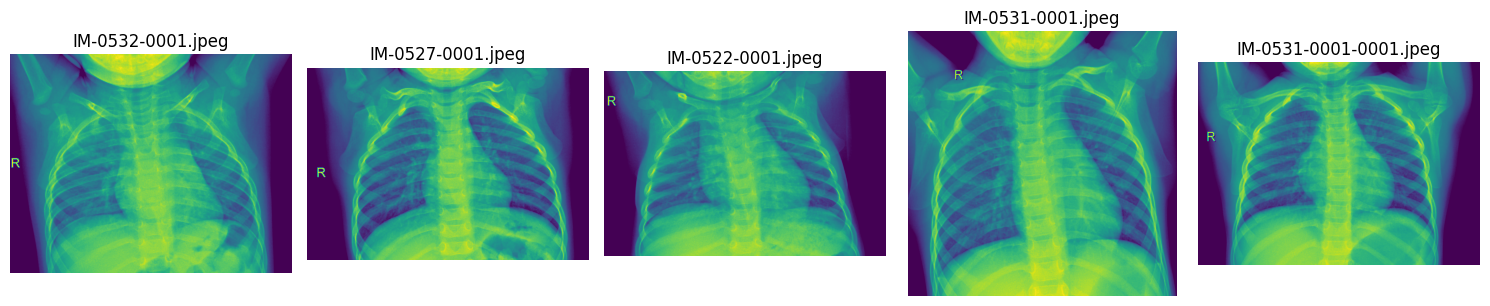

In [ ]:
path_to_visualize = "/content/drive/MyDrive/pneumonia detection/chest_xray/train/NORMAL"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

**PNEUMONIA IMAGES**

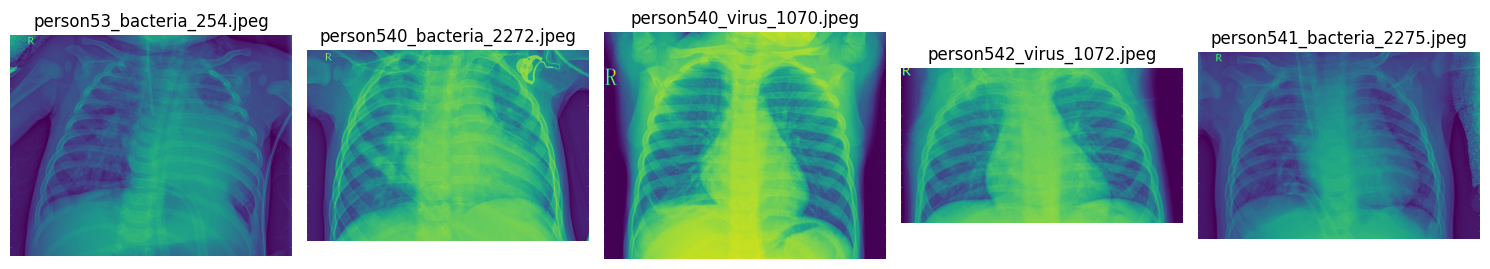

In [ ]:
# Specify the path containing the images to visualize
path_to_visualize = "/content/drive/MyDrive/pneumonia detection/chest_xray/train/PNEUMONIA"

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

**MODEL BUILDING**(TRANSFER LEARNING)

In [ ]:
# Load the Xception base model without the top (classification) layer
base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))

# Freeze the layers in the base model
base_model.trainable = False

## Load the Xception base model without the top (classification) layer
base_model = Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(256, 256, 3))

# Freeze the layers in the base model
base_model.trainable = False

# Build Model
model = Sequential()

# Base Model
model.add(base_model)

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.45))

# Dense Layer 1
model.add(Dense(220, activation='relu'))

# Dropout Layer
model.add(Dropout(0.25))

# Dense Layer 2
model.add(Dense(60,activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_8 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 220)               450780    
                                                                 
 dropout_1 (Dropout)         (None, 220)               0         
                                                                 
 dense_1 (Dense)             (None, 60)                13

**COMPLIE AND FITTING**

In [ ]:
#Early_Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Fitting Model
history = model.fit_generator(train_ds,
                        epochs= 2,
                        validation_data = validation_ds,
                        callbacks = early_stopping)

Epoch 1/2
147/147 [==============================] - 1389s 9s/step - loss: 0.1926 - accuracy: 0.9236 - val_loss: 0.1608 - val_accuracy: 0.9578
Epoch 2/2
147/147 [==============================] - 1372s 9s/step - loss: 0.1245 - accuracy: 0.9493 - val_loss: 0.0977 - val_accuracy: 0.9655


**VAL LOSS AND ACCURACY**

In [ ]:
# Evaluate the model on the validation dataset
validation_loss, validation_accuracy = model.evaluate(validation_ds)

# Print the validation loss and accuracy
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

17/17 [==============================] - 138s 8s/step - loss: 0.0977 - accuracy: 0.9655
Validation Loss: 0.09774579852819443
Validation Accuracy: 0.9654510617256165


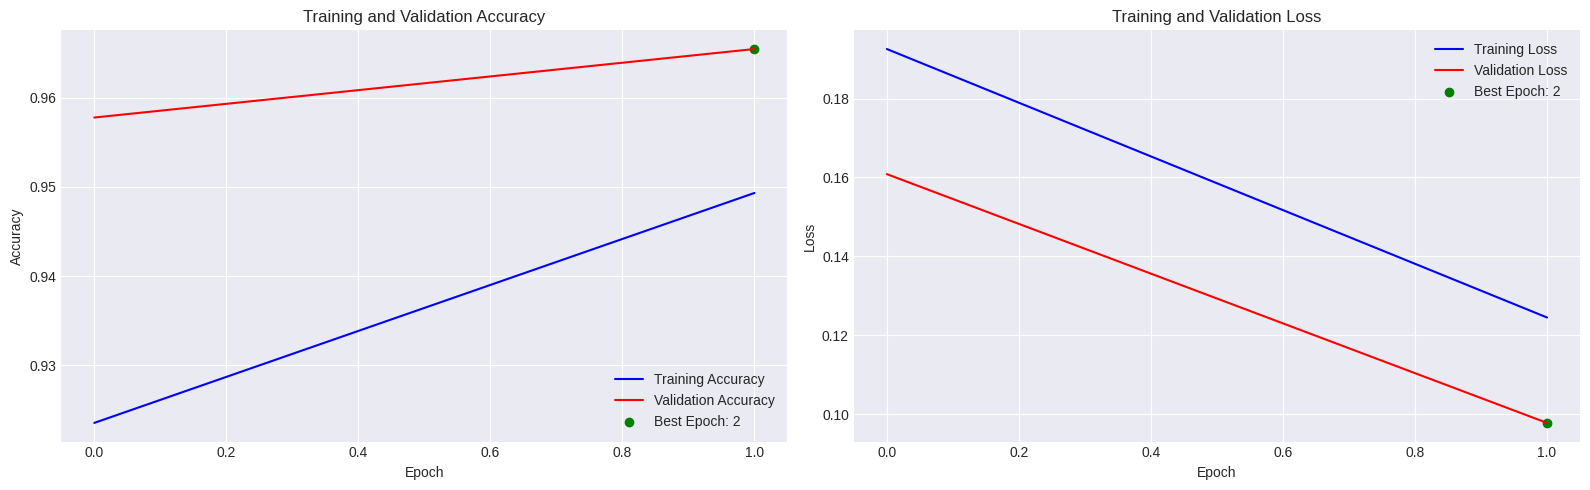

In [ ]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

# Set the background style
plt.style.use('seaborn-darkgrid')

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot training and validation accuracy
axs[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history.history['loss'], label='Training Loss', color='blue')
axs[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

**MODEL PREDICTIONS**

Testing Images:
Found 624 files belonging to 2 classes.
Testing Images:
20/20 [==============================] - 198s 8s/step


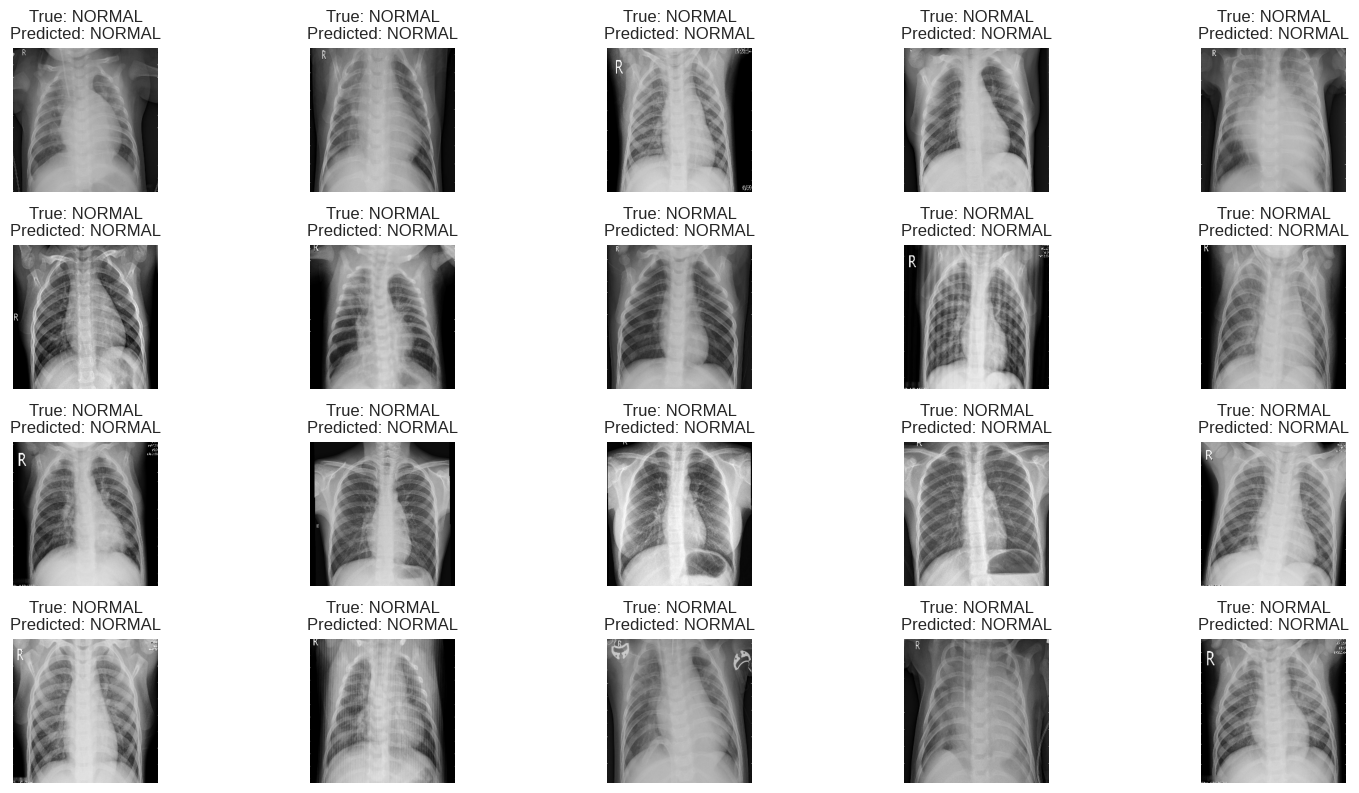

In [ ]:
test_dir = "/content/drive/MyDrive/pneumonia detection/chest_xray/test"
print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

# Define a function to plot images with their true and predicted labels
def plot_images_with_predictions(model, dataset, class_labels, num_images=40, num_images_per_row=5):
    # Generate predictions for a set number of images
    predictions = model.predict(dataset)

    # Shuffle the dataset
    dataset_shuffled = dataset.shuffle(buffer_size=len(dataset))

    plt.figure(figsize=(15, 10))
    for i, (images, labels) in enumerate(dataset_shuffled.take(num_images)):
        # Convert tensor to NumPy array
        images = images.numpy()

        # Iterate over each image in the batch
        for j in range(len(images)):
            if i * num_images_per_row + j < num_images:  # Check if the total number of images exceeds the desired count
                predicted_class = class_labels[np.argmax(predictions[i * num_images_per_row + j])]
                true_class = class_labels[np.argmax(labels[j])]

                plt.subplot(num_images // num_images_per_row + 1, num_images_per_row, i * num_images_per_row + j + 1)
                plt.imshow(images[j].astype("uint8"))
                plt.title(f'True: {true_class}\nPredicted: {predicted_class}')
                plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on random 20 images from the testing dataset
print('Testing Images:')
plot_images_with_predictions(model, test_ds, class_labels, num_images=20)

1/1 [==============================] - 0s 249ms/step


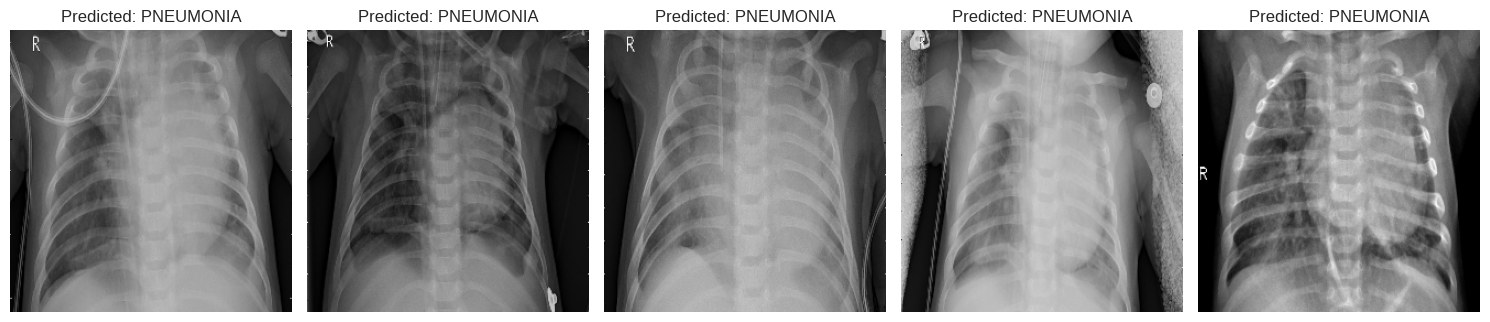

In [ ]:
# Path to the directory containing the images
directory_path = "/content/drive/MyDrive/pneumonia detection/chest_xray/test/PNEUMONIA/"

# Select N image files from the directory
image_files = os.listdir(directory_path)[:5]

# Create a figure and axes for subplots
fig, axs = plt.subplots(1, len(image_files), figsize=(15, 5))

# Load and preprocess each image, make predictions, and display them using a loop
for i, image_file in enumerate(image_files):
    img_path = os.path.join(directory_path, image_file)
    # Load the image using OpenCV
    img = cv2.imread(img_path)
    # Resize the image to (256, 256)
    img = cv2.resize(img, (256, 256))

    # Normalize pixel values
    img_array = img.astype(np.float32) / 255.0

    # Expand the dimensions to match the input shape expected by the model
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model.predict(img_array)
    actual_prediction = (predictions > 0.5).astype(int)

    # Display the image with predicted label
    # Convert BGR to RGB for displaying with matplotlib
    axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')
    if actual_prediction[0][0] == 0:
        predicted_label = 'Normal'
    else:
        predicted_label = 'PNEUMONIA'
    axs[i].set_title(f'Predicted: {predicted_label}')

# Adjust layout
plt.tight_layout()
plt.show()